<a href="https://colab.research.google.com/github/EsserMishelle/short-term-stock-forecast/blob/main/04_ml_price_based.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [479]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from xgboost import XGBRegressor

import xgboost as xgb


from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

import seaborn as sns
import os
import time

### Download from Yahoo Finance

In [480]:
TICKERS = ['NVDA', 'AMD', 'TSM','QQQ', '^VIX', '^TNX']
START_DATE = '2021-01-01'
END_DATE = '2026-02-05'

stocks = yf.download(
    TICKERS,
    start=START_DATE,
    end=END_DATE,
    group_by='ticker',
    auto_adjust=True,
    prepost=True,
    threads=True,
    progress=False
)
stocks.head(3)


Ticker       ^TNX                                    AMD             \
Price        Open   High    Low  Close Volume       Open       High   
Date                                                                  
2021-01-04  0.935  0.953  0.907  0.917      0  92.110001  96.059998   
2021-01-05  0.937  0.963  0.927  0.955      0  92.099998  93.209999   
2021-01-06  1.000  1.054  1.000  1.042      0  91.620003  92.279999   

Ticker                                      ...         QQQ              \
Price             Low      Close    Volume  ...        Open        High   
Date                                        ...                           
2021-01-04  90.919998  92.300003  51802600  ...  305.791588  305.966287   
2021-01-05  91.410004  92.769997  34208000  ...  299.173259  302.909413   
2021-01-06  89.459999  90.330002  51911700  ...  297.921456  302.657150   

Ticker                                               TSM              \
Price              Low       Close    Volume        Open        High   
Date                                                                   
2021-01-04  296.155244  300.163116  45305900  102.502915  104.921345   
2021-01-05  299.173259  302.637665  29323400  103.367292  105.702958   
2021-01-06  296.931630  298.445496  52809600  104.691447  107.027120   

Ticker                                        
Price              Low       Close    Volume  
Date                                          
2021-01-04  101.564964  102.714409  11262100  
2021-01-05  102.999469  103.698326  10583600  
2021-01-06  103.496029  106.309868  10609300  

[3 rows x 30 columns]

In [481]:
display(stocks.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1278 entries, 2021-01-04 to 2026-02-04
Data columns (total 30 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (^TNX, Open)    1278 non-null   float64
 1   (^TNX, High)    1278 non-null   float64
 2   (^TNX, Low)     1278 non-null   float64
 3   (^TNX, Close)   1278 non-null   float64
 4   (^TNX, Volume)  1278 non-null   int64  
 5   (AMD, Open)     1278 non-null   float64
 6   (AMD, High)     1278 non-null   float64
 7   (AMD, Low)      1278 non-null   float64
 8   (AMD, Close)    1278 non-null   float64
 9   (AMD, Volume)   1278 non-null   int64  
 10  (^VIX, Open)    1278 non-null   float64
 11  (^VIX, High)    1278 non-null   float64
 12  (^VIX, Low)     1278 non-null   float64
 13  (^VIX, Close)   1278 non-null   float64
 14  (^VIX, Volume)  1278 non-null   int64  
 15  (NVDA, Open)    1278 non-null   float64
 16  (NVDA, High)    1278 non-null   float64
 17  (NVDA, Low)    

None

#### There are 25 columns and 1278 rows

### Save the main file, and divide it by price and volume and save them in 2 other files

In [482]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [483]:
# Flatten columns for easier use later

stocks_flat = stocks.copy()

stocks_flat.columns = ['_'.join(col) for col in stocks_flat.columns.values]
stocks_flat.head()

,^TNX_Open,^TNX_High,^TNX_Low,^TNX_Close,^TNX_Volume,AMD_Open,AMD_High,AMD_Low,AMD_Close,AMD_Volume,...,QQQ_Open,QQQ_High,QQQ_Low,QQQ_Close,QQQ_Volume,TSM_Open,TSM_High,TSM_Low,TSM_Close,TSM_Volume
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-04,0.935,0.953,0.907,0.917,0,92.110001,96.059998,90.919998,92.300003,51802600,...,305.791588,305.966287,296.155244,300.163116,45305900,102.502915,104.921345,101.564964,102.714409,11262100
2021-01-05,0.937,0.963,0.927,0.955,0,92.099998,93.209999,91.410004,92.769997,34208000,...,299.173259,302.909413,299.173259,302.637665,29323400,103.367292,105.702958,102.999469,103.698326,10583600
2021-01-06,1.000,1.054,1.000,1.042,0,91.620003,92.279999,89.459999,90.330002,51911700,...,297.921456,302.657150,296.931630,298.445496,52809600,104.691447,107.027120,103.496029,106.309868,10609300
2021-01-07,1.056,1.088,1.054,1.071,0,91.330002,95.510002,91.199997,95.160004,42897200,...,301.104352,306.499928,301.075240,305.665375,30394800,109.739814,113.050221,108.130591,111.661690,13556100
2021-01-08,1.088,1.126,1.075,1.105,0,95.980003,96.400002,93.269997,94.580002,39816400,...,307.955707,309.945103,305.762530,309.595734,33955800,115.781309,116.130737,107.569673,109.142113,18976800


In [484]:
# Since ^VTX and ^TNX are an index and yield series and not traded security, they do not have trading volume (Volume column is 0)
# We will use 'Close' only and drop these columns

cols_to_drop = ['^VIX_Volume', '^TNX_Volume']
stocks_flat_clean = stocks_flat.drop(columns=cols_to_drop)

stocks_flat_clean.to_csv(
    '/content/drive/MyDrive/stocks/stocks_raw_2021_2026_clean.csv',
    index=True
)

print("Saved: stock_raw_2021_2026_clean.csv")

Saved: stock_raw_2021_2026_clean.csv


In [485]:
stocks_flat_clean.columns

Index(['^TNX_Open', '^TNX_High', '^TNX_Low', '^TNX_Close', 'AMD_Open',
       'AMD_High', 'AMD_Low', 'AMD_Close', 'AMD_Volume', '^VIX_Open',
       '^VIX_High', '^VIX_Low', '^VIX_Close', 'NVDA_Open', 'NVDA_High',
       'NVDA_Low', 'NVDA_Close', 'NVDA_Volume', 'QQQ_Open', 'QQQ_High',
       'QQQ_Low', 'QQQ_Close', 'QQQ_Volume', 'TSM_Open', 'TSM_High', 'TSM_Low',
       'TSM_Close', 'TSM_Volume'],
      dtype='object')

In [602]:
# Select only closing price-related columns
price_cols = [c for c in stocks_flat_clean.columns if 'Close' in c or 'Adj Close' in c]
price_df = stocks_flat_clean[price_cols]

price_df.to_csv(
    '/content/drive/MyDrive/stocks/stock_price_2021_2026.csv',
    index=True
)
print("- stock_price_2021_2026.csv")
price_df.head()

- stock_price_2021_2026.csv


,^TNX_Close,AMD_Close,^VIX_Close,NVDA_Close,QQQ_Close,TSM_Close
Date,,,,,,
2021-01-04,0.917,92.300003,26.969999,13.076727,300.163116,102.714409
2021-01-05,0.955,92.769997,25.340000,13.367159,302.637665,103.698326
2021-01-06,1.042,90.330002,25.070000,12.579126,298.445496,106.309868
2021-01-07,1.071,95.160004,22.370001,13.306581,305.665375,111.661690
2021-01-08,1.105,94.580002,21.559999,13.239517,309.595734,109.142113


In [603]:
# Select only volume-related columns
volume_cols = [c for c in stocks_flat_clean.columns if 'Volume' in c]
volume_df = stocks_flat_clean[volume_cols]

volume_df.to_csv(
    '/content/drive/MyDrive/stocks/stock_volume_2021_2026.csv',
    index=True
)
print("- stock_volume_2021_2026.csv")
volume_df.head()


- stock_volume_2021_2026.csv


,AMD_Volume,NVDA_Volume,QQQ_Volume,TSM_Volume
Date,,,,
2021-01-04,51802600,560640000,45305900,11262100
2021-01-05,34208000,322760000,29323400,10583600
2021-01-06,51911700,580424000,52809600,10609300
2021-01-07,42897200,461480000,30394800,13556100
2021-01-08,39816400,292528000,33955800,18976800


### Load NVDA price and volume and merge them together

In [604]:
import pandas as pd

# --- Load the two FILES ---
price_df = pd.read_csv(
    '/content/drive/MyDrive/stocks/stock_price_2021_2026.csv',
    index_col='Date',
    parse_dates=True
)

volume_df = pd.read_csv(
    '/content/drive/MyDrive/stocks/stock_volume_2021_2026.csv',
    index_col='Date',
    parse_dates=True
)

# Keep only NVDA for now
p = price_df[[('NVDA_Close')]].copy()
v = volume_df[[('NVDA_Volume')]].copy()

# Rename column names
p.columns = ['nvda_close']
v.columns = ['nvda_volume']

# Merge price + volume by date
df = p.join(v, how='inner')

display(df.info())
print()

display(df.describe())
print()

display(df.head())
print()
display(df.tail())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1278 entries, 2021-01-04 to 2026-02-04
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   nvda_close   1278 non-null   float64
 1   nvda_volume  1278 non-null   int64  
dtypes: float64(1), int64(1)
memory usage: 30.0 KB


None

,nvda_close,nvda_volume
count,1278.000000,1.278000e+03
mean,69.329726,3.907986e+08
std,59.103824,1.843901e+08
min,11.212905,6.552850e+07
25%,19.515133,2.365302e+08
50%,42.327457,3.756440e+08
75%,121.585548,5.028558e+08
max,207.028473,1.543911e+09


,nvda_close,nvda_volume
Date,,
2021-01-04,13.076727,560640000
2021-01-05,13.367159,322760000
2021-01-06,12.579126,580424000
2021-01-07,13.306581,461480000
2021-01-08,13.239517,292528000


,nvda_close,nvda_volume
Date,,
2026-01-29,192.509995,171764400
2026-01-30,191.130005,179489500
2026-02-02,185.610001,165794100
2026-02-03,180.339996,204019600
2026-02-04,174.190002,207014100


In [548]:
print(price_df.columns)
print(volume_df.columns)

Index(['^TNX_Close', 'AMD_Close', '^VIX_Close', 'NVDA_Close', 'QQQ_Close',
       'TSM_Close'],
      dtype='object')
Index(['AMD_Volume', 'NVDA_Volume', 'QQQ_Volume', 'TSM_Volume'], dtype='object')


#### The time frame of the dataset is: 2021-01-04 to 2026-02-04.  There are 2 columns, 1278 rows and no null values.

### Feature Engineering

#### Univariate based on NVDA Closing Price and Volume

In [605]:
# ---------- PRICE FEATURES ----------
# Lagged prices (autoregressive features)
df['lag_1_price'] = df['nvda_close'].shift(1)
df['lag_2_price'] = df['nvda_close'].shift(2)
df['lag_5_price'] = df['nvda_close'].shift(5)

# Moving Avg (Different timeframe trends indicators)
df['roll5_price'] = df['nvda_close'].rolling(5).mean()
df['roll10_price'] = df['nvda_close'].rolling(10).mean()
df['roll20_price'] = df['nvda_close'].rolling(20).mean()
df['roll60_price'] = df['nvda_close'].rolling(60).mean()

# How much is price fluctuating?
df['volatility_5d'] = df['nvda_close'].rolling(5).std()   # Short-term vol
df['volatility_20d'] = df['nvda_close'].rolling(20).std() # Longer-term vol

# MACD (Moving Average Convergence Divergence)
df['ema_12'] = df['nvda_close'].ewm(span=12, adjust=False).mean()
df['ema_26'] = df['nvda_close'].ewm(span=26, adjust=False).mean()

# Trading activity signals
df['volume_ma_20'] = df['nvda_volume'].rolling(20).mean()

df['price_volume'] = df['nvda_close'] * df['nvda_volume']  # Dollar volume
df['price_volume_ma'] = df['price_volume'].rolling(20).mean()

# # ---------- TARGET: 30 days ahead ----------
df['y_30'] = df['nvda_close'].shift(-30)

# Drop NaN rows
df_model = df.dropna()

display(df_model.head())
print()
display(df_model.tail())
display(df_model.shape)

,nvda_close,nvda_volume,lag_1_price,lag_2_price,lag_5_price,roll5_price,roll10_price,roll20_price,roll60_price,volatility_5d,volatility_20d,ema_12,ema_26,volume_ma_20,price_volume,price_volume_ma,y_30
Date,,,,,,,,,,,,,,,,,
2021-03-30,12.840083,200204000,12.916393,12.807664,13.038595,12.736089,12.868663,12.745430,13.405816,0.171425,0.398447,12.867720,13.049082,335829000.0,2.570636e+09,4.246981e+09,13.724653
2021-03-31,13.315413,314776000,12.840083,12.916393,12.611896,12.876793,12.869361,12.772759,13.409794,0.291012,0.418383,12.936596,13.068810,332688200.0,4.191373e+09,4.215479e+09,13.631631
2021-04-01,13.777772,308276000,13.315413,12.840083,12.504411,13.131465,12.978018,12.844870,13.416638,0.414595,0.461163,13.066008,13.121326,319434800.0,4.247356e+09,4.074221e+09,14.207961
2021-04-05,13.953091,255672000,13.777772,13.315413,12.807664,13.360550,13.091913,12.921196,13.439537,0.498843,0.511828,13.202482,13.182938,305076400.0,3.567415e+09,3.915310e+09,14.130651
2021-04-06,13.827399,191744000,13.953091,13.777772,12.916393,13.542752,13.159272,13.034529,13.448218,0.460994,0.440746,13.298623,13.230676,287508000.0,2.651321e+09,3.733937e+09,13.981270


,nvda_close,nvda_volume,lag_1_price,lag_2_price,lag_5_price,roll5_price,roll10_price,roll20_price,roll60_price,volatility_5d,volatility_20d,ema_12,ema_26,volume_ma_20,price_volume,price_volume_ma,y_30
Date,,,,,,,,,,,,,,,,,
2025-12-15,176.289993,164775600,175.020004,180.929993,185.550003,180.197998,181.335991,181.240453,185.959662,4.422179,3.305722,180.808441,183.032471,205880805.0,2.904829e+10,3.728843e+10,192.509995
2025-12-16,177.720001,148588100,176.289993,175.020004,184.970001,178.747998,180.963000,180.796972,185.861666,3.573466,3.141192,180.333296,182.638955,204628765.0,2.640708e+10,3.698891e+10,191.130005
2025-12-17,170.940002,222775500,177.720001,176.289993,183.779999,176.179999,180.099001,180.276477,185.736998,3.665696,3.831384,178.888174,181.772366,205087595.0,3.808124e+10,3.695617e+10,185.610001
2025-12-18,174.139999,176096000,170.940002,177.720001,180.929993,174.822000,179.175000,179.657996,185.689996,2.555761,3.770136,178.157686,181.207005,201530075.0,3.066536e+10,3.618374e+10,180.339996
2025-12-19,180.990005,324925900,174.139999,170.940002,175.020004,176.016000,179.033000,179.675999,185.745160,3.775068,3.775876,178.593427,181.190931,200601130.0,5.880834e+10,3.602180e+10,174.190002


(1189, 17)

#### After feature-engineered, the timeframe is now from: 03-30-2021 to 12-19-2025. There are 17 columns and 1179 rows.

## Peason Correlation by NVDA Closing Price

In [550]:
df_heatmap=df_model.corr().sort_values(by='y_30', key= abs, ascending=False).round(2)
df_heatmap

,nvda_close,nvda_volume,lag_1_price,lag_2_price,lag_5_price,roll5_price,roll10_price,roll20_price,roll60_price,volatility_5d,volatility_20d,ema_12,ema_26,volume_ma_20,price_volume,price_volume_ma,y_30
y_30,0.98,-0.55,0.98,0.98,0.97,0.98,0.98,0.97,0.97,0.67,0.77,0.98,0.97,-0.71,0.70,0.80,1.00
nvda_close,1.00,-0.55,1.00,1.00,1.00,1.00,1.00,1.00,0.99,0.69,0.78,1.00,1.00,-0.72,0.70,0.81,0.98
lag_1_price,1.00,-0.55,1.00,1.00,1.00,1.00,1.00,1.00,0.99,0.69,0.78,1.00,1.00,-0.72,0.70,0.81,0.98
roll5_price,1.00,-0.55,1.00,1.00,1.00,1.00,1.00,1.00,0.99,0.69,0.78,1.00,1.00,-0.72,0.70,0.81,0.98
lag_2_price,1.00,-0.55,1.00,1.00,1.00,1.00,1.00,1.00,0.99,0.69,0.78,1.00,1.00,-0.72,0.70,0.81,0.98
ema_12,1.00,-0.55,1.00,1.00,1.00,1.00,1.00,1.00,0.99,0.69,0.78,1.00,1.00,-0.72,0.70,0.81,0.98
roll10_price,1.00,-0.55,1.00,1.00,1.00,1.00,1.00,1.00,0.99,0.69,0.78,1.00,1.00,-0.72,0.70,0.81,0.98
ema_26,1.00,-0.55,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.70,0.78,1.00,1.00,-0.72,0.69,0.80,0.97
lag_5_price,1.00,-0.55,1.00,1.00,1.00,1.00,1.00,1.00,0.99,0.69,0.78,1.00,1.00,-0.72,0.70,0.81,0.97
roll20_price,1.00,-0.55,1.00,1.00,1.00,1.00,1.00,1.00,0.99,0.69,0.77,1.00,1.00,-0.72,0.69,0.81,0.97


<Axes: >

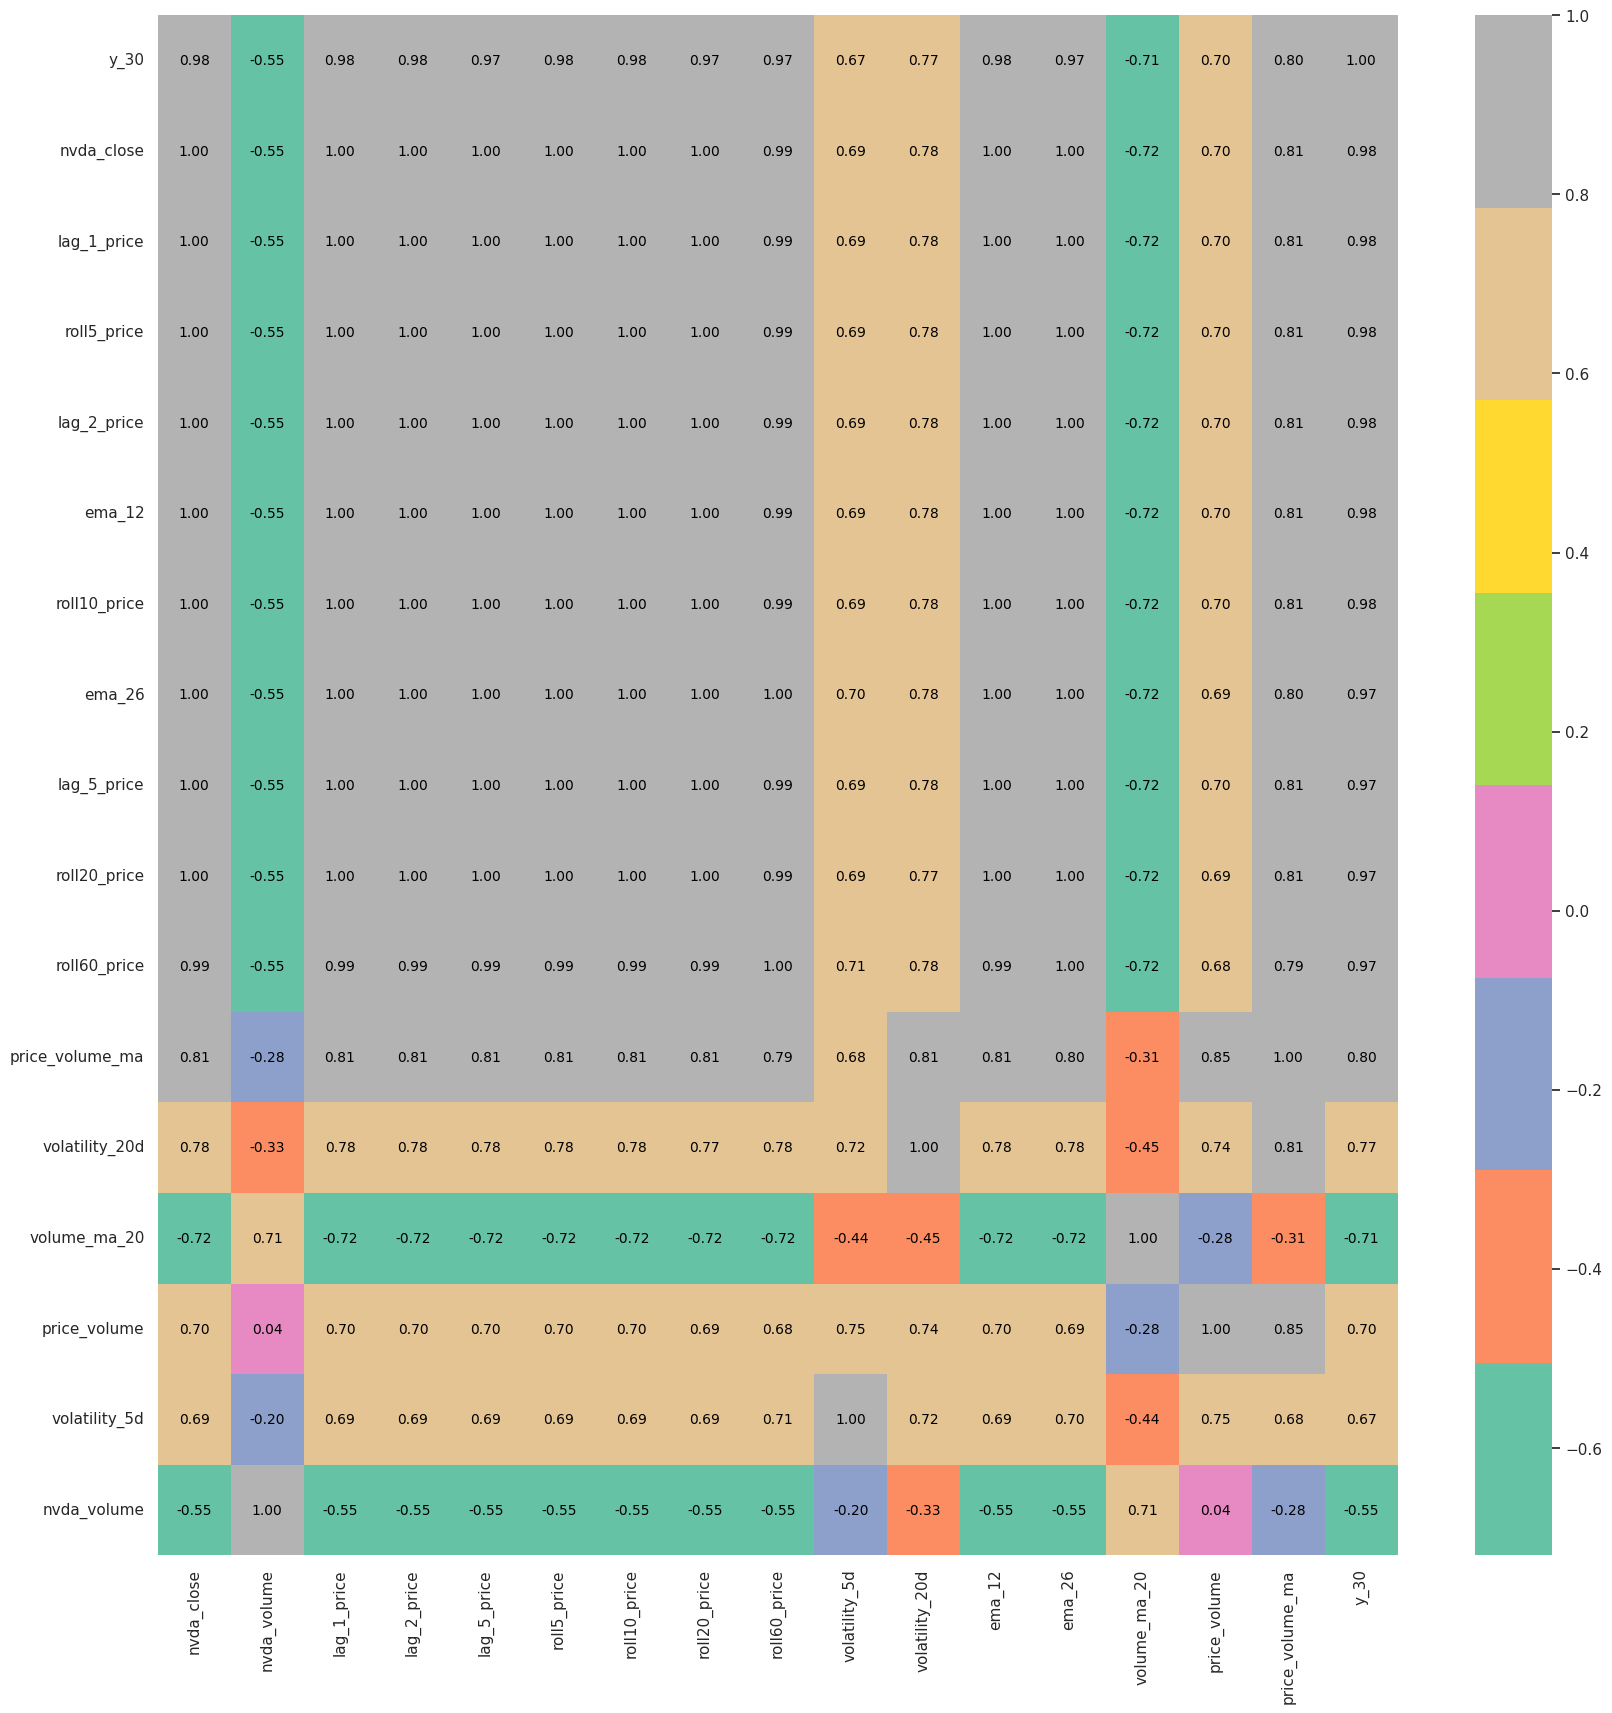

In [551]:
sns.set_theme(style="darkgrid")
plt.figure(figsize=(20,20))
sns.heatmap(df_heatmap, annot=True, cmap='Set2', annot_kws={'fontsize': 10, 'color': 'black'}, fmt='.2f')

### Time-Based Train-Test-Split

In [606]:
split_date = pd.to_datetime('2025-02-03') # first business date in Feb, 2025

#### Make a metric function

In [607]:
# Function for the metrics

def evaluate_direct_price_model(df, feature_cols, horizon, split_date):

    df_model = df.copy()

    # Create future target
    df_model['y'] = df_model['nvda_close'].shift(-horizon)
    df_model = df_model.dropna()

    # Split
    train = df_model[df_model.index < split_date]
    test  = df_model[df_model.index >= split_date]

    X_train = train[feature_cols]
    y_train = train['y']

    X_test  = test[feature_cols]
    y_test  = test['y']

    model = LinearRegression()
    model.fit(X_train, y_train)

    y_pred_train = model.predict(X_train)
    y_pred_test  = model.predict(X_test)

    results = {
        "Horizon": horizon,
        "Train_MAE": mean_absolute_error(y_train, y_pred_train),
        "Test_MAE":  mean_absolute_error(y_test, y_pred_test),
        "Train_RMSE": np.sqrt(mean_squared_error(y_train, y_pred_train)),
        "Test_RMSE":  np.sqrt(mean_squared_error(y_test, y_pred_test)),
        "Train_MAPE": np.mean(np.abs((y_train - y_pred_train) / y_train)) * 100,
        "Test_MAPE":  np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100,
    }

    return results, model, test.index, y_test, y_pred_test


### Liner Regression (Univariate)

In [619]:
train = df_model[df_model.index < split_date]
test  = df_model[df_model.index >= split_date]

X_cols_uni = [
'lag_1_price',
# 'lag_2_price',
'lag_5_price',

# Moving Avg (trend indicators)
'roll5_price',
# 'roll10_price',
# 'roll20_price',
# 'roll60_price',

# How much is price fluctuating?
'volatility_5d',
# 'volatility_20d',

# MACD (Moving Average Convergence Divergence)
# 'ema_12',
# 'ema_26',

# Trading activity signals
'volume_ma_20',

# 'price_volume',
# 'price_volume_ma'
]

# Train the Model
X_train = train[X_cols_uni]
y_train = train['y_30']

X_test = test[X_cols_uni]
y_test = test['y_30']

print(f"Shapes: X_train: {X_train.shape}; y_train: {y_train.shape}; X_test: {X_test.shape}; y_test: {y_test.shape}")

Shapes: X_train: (966, 5); y_train: (966,); X_test: (223, 5); y_test: (223,)


,Horizon,Train_MAE,Test_MAE,Train_RMSE,Test_RMSE,Train_MAPE,Test_MAPE
0,5,3.046847,7.186574,4.827628,8.850188,6.397157,4.954356
1,10,4.116334,9.543682,6.310283,11.622503,9.138133,6.505680
2,20,5.598120,12.568091,8.443194,14.927428,12.756210,8.605250
3,30,7.093256,15.224412,10.562778,18.867811,16.250886,10.273087


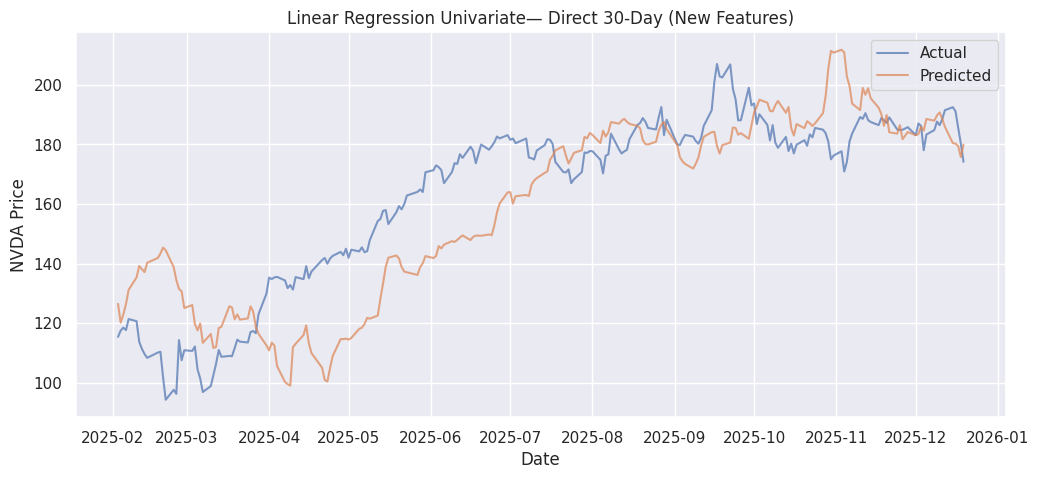

In [620]:
# Horizons (Various timeframes to test)
horizons = [5, 10, 20, 30]
results_lr_uni = []

for h in horizons:
    metrics, model, test_idx, y_test, y_pred = evaluate_direct_price_model(
        df=df,
        feature_cols=X_cols_uni,
        horizon=h,
        split_date=split_date
    )

    results_lr_uni.append(metrics)

price_lr_uni_df = pd.DataFrame(results_lr_uni)
display(price_lr_uni_df)

print()

plt.figure(figsize=(12,5))
plt.plot(test_idx, y_test, label='Actual', alpha=0.7)
plt.plot(test_idx, y_pred, label='Predicted', alpha=0.7)
plt.title('Linear Regression Univariate— Direct 30-Day (New Features)')
plt.xlabel('Date')
plt.ylabel('NVDA Price')
plt.legend()
plt.show()

### Interpretation

#### As expected, forecast error increases as the horizon expands.

- 5-day horizon shows lowest error (RMSE = 9.41 test).
- 10- and 20-day horizons show moderate degradation.
- 30-day horizon exhibits the largest test error.

#### This confirms that longer forecast horizons accumulate uncertainty and are harder to predict accurately.

#### The increase appears approximately monotonic, suggesting stable model behavior rather than overfitting.

### Visual Interpretation:

#### The predicted values track overall trend but lag during regime shifts.
#### Error widens during high-volatility periods.


## Logistic Regression (Multivariate: NVDA + QQQ + amd + VIX + TNX)
### Rebuild the Model

In [624]:
# Load flattened files again

price_df = pd.read_csv(
    '/content/drive/MyDrive/stocks/stock_price_2021_2026.csv',
    index_col='Date',
    parse_dates=True
)

volume_df = pd.read_csv(
    '/content/drive/MyDrive/stocks/stock_volume_2021_2026.csv',
    index_col='Date',
    parse_dates=True
)

In [625]:
# Build base dataframe with ALL relevant series

# 'Close' columns
close_cols = [
    'NVDA_Close',
    'QQQ_Close',
    'AMD_Close',
    'TSM_Close',
    '^VIX_Close',
    '^TNX_Close'
]

# 'Volume' columns (VIX and TNX typically have 0 volume)
volume_cols = [
    'NVDA_Volume',
    'QQQ_Volume',
    'AMD_Volume',
    'TSM_Volume'
]

# Concatenate price + volume
df = pd.concat([
    price_df[close_cols],
    volume_df[volume_cols]
], axis=1)

# Drop rows with missing values
df = df.dropna()
df.columns = df.columns.str.lower()

df.head()

,nvda_close,qqq_close,amd_close,tsm_close,^vix_close,^tnx_close,nvda_volume,qqq_volume,amd_volume,tsm_volume
Date,,,,,,,,,,
2021-01-04,13.076727,300.163116,92.300003,102.714409,26.969999,0.917,560640000,45305900,51802600,11262100
2021-01-05,13.367159,302.637665,92.769997,103.698326,25.340000,0.955,322760000,29323400,34208000,10583600
2021-01-06,12.579126,298.445496,90.330002,106.309868,25.070000,1.042,580424000,52809600,51911700,10609300
2021-01-07,13.306581,305.665375,95.160004,111.661690,22.370001,1.071,461480000,30394800,42897200,13556100
2021-01-08,13.239517,309.595734,94.580002,109.142113,21.559999,1.105,292528000,33955800,39816400,18976800


### Feature Engineering with Multiple New Series

In [626]:
# TARGET (unchanged): NVDA 30 days ahead
df['y_30'] = df['nvda_close'].shift(-30)

# SELECTED FEATURES

# price persistence
df['nvda_price_lag1'] = df['nvda_close'].shift(1)
df['nvda_price_lag7'] = df['nvda_close'].shift(7)
df['nvda_price_lag14'] = df['nvda_close'].shift(14)
df['amd_price_lag1'] = df['amd_close'].shift(1)
df['tsm_close'] = df['tsm_close']
df['tsm_close_lag1'] = df['tsm_close'].shift(1)

# volume regime
df['nvda_vol_roll7'] = df['nvda_volume'].rolling(7).mean()

# stock rolling trends
df['qqq_roll7'] = df['qqq_close'].rolling(7).mean()
# df['qqq_roll14'] = df['qqq_close'].rolling(14).mean()

df['amd_roll7'] = df['amd_close'].rolling(7).mean()
# df['amd_roll14'] = df['amd_close'].rolling(14).mean()

df['tsm_roll7'] = df['tsm_close'].rolling(7).mean()
# df['tsm_roll14'] = df['tsm_close'].rolling(14).mean()

df['nvda_ema_12'] = df['nvda_close'].ewm(span=12, adjust=False).mean()
df['tsm_ema_12'] = df['tsm_close'].ewm(span=12, adjust=False).mean()

# risk & rates (7-day and 14-day lag as chosen)
df['vix_lag7'] = df['^vix_close'].shift(7)
# df['vix_lag14'] = df['^vix_close'].shift(14)
df['tnx_lag7'] = df['^tnx_close'].shift(7)
# df['tnx_lag14'] = df['^tnx_close'].shift(14)

df['nvda_volatility_7'] = df['nvda_volume'].rolling(7).std()
df['tsm_volatility_7'] = df['tsm_volume'].rolling(7).std()


# seasonality
# df['week_of_year'] = df.index.isocalendar().week.astype(int)
# df['month'] = df.index.month
# df['quarter'] = df.index.quarter

# Final modeling dataframe
# ----------------------------------------------------
df_model = df.dropna()

print("New modeling shape:", df_model.shape)
print(df_model.head(2))

New modeling shape: (1234, 26)
            nvda_close   qqq_close  amd_close   tsm_close  ^vix_close  \
Date                                                                    
2021-01-25   13.614960  318.407166  94.129997  120.020470   23.190001   
2021-01-26   13.397573  318.873047  94.709999  116.461769   23.020000   

            ^tnx_close  nvda_volume  qqq_volume  amd_volume  tsm_volume  ...  \
Date                                                                     ...   
2021-01-25        1.04    251112000    39080600    55086900    20469300  ...   
2021-01-26        1.04    163980000    25498100    59449100    17084600  ...   

            nvda_vol_roll7   qqq_roll7  amd_roll7   tsm_roll7  nvda_ema_12  \
Date                                                                         
2021-01-25    2.687674e+08  311.407615  90.807142  119.205990    13.381942   
2021-01-26    2.517474e+08  313.381744  91.367142  119.232264    13.384346   

            tsm_ema_12   vix_lag7  tnx_lag

In [627]:
df_model.corr().sort_values(by='y_30', key= abs, ascending=False).round(3)

,nvda_close,qqq_close,amd_close,tsm_close,^vix_close,^tnx_close,nvda_volume,qqq_volume,amd_volume,tsm_volume,...,nvda_vol_roll7,qqq_roll7,amd_roll7,tsm_roll7,nvda_ema_12,tsm_ema_12,vix_lag7,tnx_lag7,nvda_volatility_7,tsm_volatility_7
y_30,0.979,0.950,0.725,0.913,-0.333,0.635,-0.522,-0.241,-0.311,0.175,...,-0.625,0.948,0.725,0.910,0.977,0.908,-0.330,0.641,-0.363,0.146
nvda_close,1.000,0.970,0.746,0.946,-0.342,0.617,-0.527,-0.249,-0.304,0.180,...,-0.631,0.969,0.747,0.944,0.998,0.943,-0.334,0.623,-0.362,0.144
nvda_price_lag1,0.999,0.970,0.744,0.945,-0.337,0.616,-0.526,-0.245,-0.305,0.183,...,-0.631,0.970,0.747,0.944,0.998,0.944,-0.335,0.622,-0.363,0.146
nvda_ema_12,0.998,0.969,0.739,0.946,-0.323,0.615,-0.527,-0.234,-0.306,0.188,...,-0.632,0.971,0.744,0.947,1.000,0.947,-0.332,0.621,-0.365,0.150
nvda_price_lag7,0.994,0.966,0.734,0.944,-0.315,0.612,-0.523,-0.225,-0.306,0.193,...,-0.630,0.969,0.742,0.945,0.998,0.946,-0.341,0.619,-0.364,0.155
nvda_price_lag14,0.989,0.962,0.722,0.942,-0.294,0.608,-0.525,-0.214,-0.307,0.193,...,-0.630,0.965,0.730,0.943,0.995,0.945,-0.314,0.615,-0.369,0.150
qqq_close,0.970,1.000,0.799,0.956,-0.415,0.493,-0.552,-0.279,-0.318,0.129,...,-0.660,0.997,0.797,0.953,0.969,0.953,-0.400,0.500,-0.329,0.129
qqq_roll7,0.969,0.997,0.795,0.955,-0.388,0.492,-0.545,-0.252,-0.316,0.140,...,-0.660,1.000,0.800,0.956,0.971,0.956,-0.405,0.498,-0.332,0.132
tsm_close,0.946,0.956,0.742,1.000,-0.281,0.379,-0.578,-0.202,-0.300,0.141,...,-0.697,0.955,0.740,0.997,0.946,0.997,-0.273,0.386,-0.358,0.109
tsm_close_lag1,0.945,0.955,0.740,0.998,-0.273,0.378,-0.576,-0.195,-0.300,0.140,...,-0.697,0.956,0.741,0.998,0.946,0.998,-0.274,0.385,-0.357,0.108


### Use Laso Regression to find feature importance

In [628]:
train = df_model[df_model.index < split_date]
test  = df_model[df_model.index >= split_date]

X_cols_mul = [
'nvda_price_lag1',
'nvda_price_lag7',
'nvda_price_lag14',

'amd_price_lag1',
'tsm_close',
'tsm_close_lag1',

# Moving Avg (trend indicators)

'nvda_vol_roll7',
'qqq_roll7',
'amd_roll7',
'tsm_roll7',

'vix_lag7',
'tnx_lag7',
# How much is price fluctuating?
'nvda_volatility_7',
'tsm_volatility_7',

# MACD (Moving Average Convergence Divergence)
'nvda_ema_12',
# 'nvda_ema_26',
'tsm_ema_12',
]

# Train the Model
X_train_mul = train[X_cols_mul]
y_train_mul = train['y_30']

X_test_mul = test[X_cols_mul]
y_test_mul = test['y_30']

print(f"Shapes: X_train: {X_train.shape}; y_train: {y_train.shape}; X_test: {X_test.shape}; y_test: {y_test.shape}")

Shapes: X_train: (966, 5); y_train: (966,); X_test: (223, 5); y_test: (223,)


In [629]:
# Find feature importance thru lasso regression

from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_mul)
X_test_scaled = scaler.transform(X_test_mul)

lasso = Lasso(alpha=0.1, max_iter=10000, random_state=42)
lasso.fit(X_train_scaled, y_train_mul)

y_pred_train = lasso.predict(X_train_scaled)
y_pred_test  = lasso.predict(X_test_scaled)

def metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mae, rmse, mape

mae_tr, rmse_tr, mape_tr = metrics(y_train_mul, y_pred_train)
mae_te, rmse_te, mape_te = metrics(y_test_mul, y_pred_test)

print("TRAIN:", mae_tr, rmse_tr, mape_tr)
print("TEST :", mae_te, rmse_te, mape_te)

TRAIN: 6.625064292257704 9.184906751025709 16.682323421149167
TEST : 18.935267793493264 23.729438428146818 12.123223643229762


In [630]:
coef_df = pd.DataFrame({
    'Feature': X_cols_mul,
    'Coefficient': lasso.coef_,
    'Abs_Coefficient': np.abs(lasso.coef_)
})

coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False)

display(coef_df)

,Feature,Coefficient,Abs_Coefficient
0,nvda_price_lag1,18.936282,18.936282
2,nvda_price_lag14,7.670052,7.670052
3,amd_price_lag1,6.549918,6.549918
14,nvda_ema_12,6.126950,6.126950
11,tnx_lag7,5.384945,5.384945
6,nvda_vol_roll7,-2.823423,2.823423
7,qqq_roll7,-1.391790,1.391790
4,tsm_close,0.844753,0.844753
10,vix_lag7,-0.627361,0.627361
12,nvda_volatility_7,0.123030,0.123030


## Logistic Regression (Multivariate using Lasso Produced Features)

In [639]:
# Refit LR with the strong coefficient features and some highly correlated features

X_cols_filtered= [
 'nvda_price_lag1',
#  'nvda_price_lag7',
 'nvda_price_lag14',
 'nvda_ema_12',
 'tsm_close',
#  'tsm_close_lag1',
 'amd_price_lag1',
 'qqq_roll7',
 'tnx_lag7',
 'nvda_vol_roll7',
#  'nvda_volatility_7'
]

# Train the Model
X_train_filtered  = train[X_cols_filtered]
y_train_filtered = train['y_30']

X_test_filtered = test[X_cols_filtered]
y_test_filtered = test['y_30']

,Horizon,Train_MAE,Test_MAE,Train_RMSE,Test_RMSE,Train_MAPE,Test_MAPE
0,5,2.979339,8.323367,4.619189,9.725750,6.924651,5.645957
1,10,3.991610,10.351666,5.997553,12.476208,9.679858,6.980848
2,20,5.327194,14.778607,7.674702,17.795105,13.383491,9.727961
3,30,6.686681,19.878209,9.170213,24.643139,17.423629,12.558980


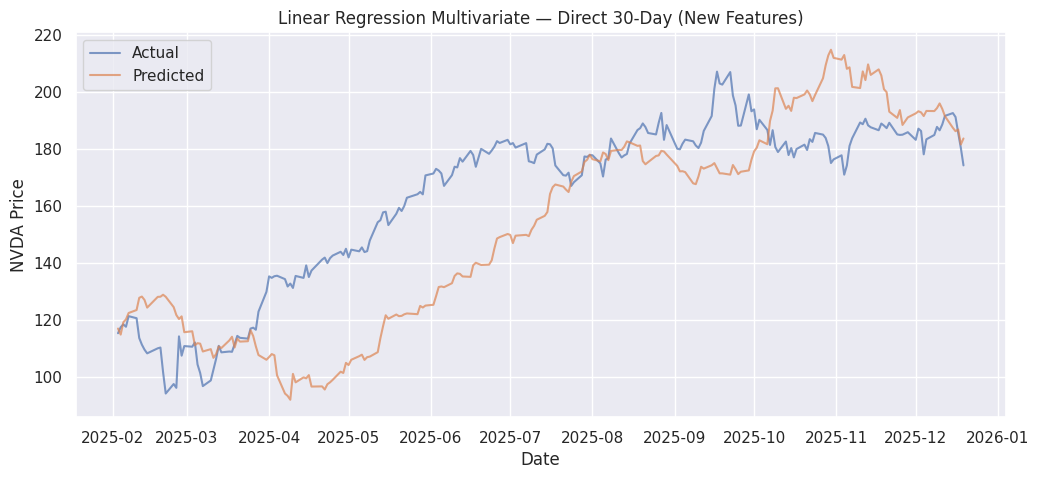

In [641]:
# Multivariate LR Model
horizons = [5, 10, 20, 30]
results_filtered_lr = []

for h in horizons:
    metrics, model, test_idx, y_test, y_pred = evaluate_direct_price_model(
        df=df,
        feature_cols=X_cols_filtered,
        horizon=h,
        split_date=split_date
    )

    results_filtered_lr.append(metrics)

price_filtered_lr_df = pd.DataFrame(results_filtered_lr)
display(price_filtered_lr_df)

print()

plt.figure(figsize=(12,5))
plt.plot(test_idx, y_test, label='Actual', alpha=0.7)
plt.plot(test_idx, y_pred, label='Predicted', alpha=0.7)
plt.title('Linear Regression Multivariate — Direct 30-Day (New Features)')
plt.xlabel('Date')
plt.ylabel('NVDA Price')
plt.legend()
plt.show()

The best Multivariate Price-Based LR Model performs slightly better than the Univeriate Price-Base LR Model. The improvement is not very significant, meaning the either the price dominates

# Return-Based Model

The return-based model changes only the target, train Linear Regression again but predicts returns. After obtaining the predicitons, convert back to price. For example: future_price = last_price * (1 + predicted_return). Right now the correlation table shows: corr(y_30, nvda_price_lag1) ≈ 0.98. Switching to returns, it is likely that the value of corr(y_30_ret, nvda_price_lag1) much lower would be much lower. This means the model learns relationship and not just copy today's price forward.

Return modeling does NOT always improve MAE dramatically. It improves:
Statistical correctness

Stability

Interpretability

Compatibility with nonlinear models

In [677]:
# Remove and rename columns that have ^

# Rebuild the model
close_cols = [
    'NVDA_Close',
    'QQQ_Close',
    'AMD_Close',
    'TSM_Close',
    '^VIX_Close',
    '^TNX_Close'
]

# Only NVDA volume
vol_cols = ['NVDA_Volume']

df_ret_base = pd.concat(
    [price_df[close_cols], volume_df[vol_cols]],
    axis=1
).dropna()

# lowercase + remove '^' so column names are easy to reference later
df_ret_base.columns = (
    df_ret_base.columns
    .str.lower()
    .str.replace('^', '', regex=False)
)

df_ret_base.head()


,nvda_close,qqq_close,amd_close,tsm_close,vix_close,tnx_close,nvda_volume
Date,,,,,,,
2021-01-04,13.076727,300.163116,92.300003,102.714409,26.969999,0.917,560640000
2021-01-05,13.367159,302.637665,92.769997,103.698326,25.340000,0.955,322760000
2021-01-06,12.579126,298.445496,90.330002,106.309868,25.070000,1.042,580424000
2021-01-07,13.306581,305.665375,95.160004,111.661690,22.370001,1.071,461480000
2021-01-08,13.239517,309.595734,94.580002,109.142113,21.559999,1.105,292528000


In [678]:
# Create Daily Returns (from closes)
ret_cols = ['nvda_close', 'qqq_close', 'amd_close', 'tsm_close', 'vix_close', 'tnx_close']
df_ret = df_ret_base[ret_cols].pct_change()

# rename return columns clearly
df_ret.columns = [c.replace('_close', '_ret1') for c in df_ret.columns]

df_ret.head()

,nvda_ret1,qqq_ret1,amd_ret1,tsm_ret1,vix_ret1,tnx_ret1
Date,,,,,,
2021-01-04,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-05,0.022210,0.008244,0.005092,0.009579,-0.060437,0.041439
2021-01-06,-0.058953,-0.013852,-0.026302,0.025184,-0.010655,0.091100
2021-01-07,0.057830,0.024192,0.053471,0.050342,-0.107698,0.027831
2021-01-08,-0.005040,0.012858,-0.006095,-0.022564,-0.036209,0.031746


In [679]:
# We’ll keep raw + returns together and remove NaN
df_ret_model = pd.concat([df_ret_base, df_ret], axis=1).dropna()
df_ret_model.head()

,nvda_close,qqq_close,amd_close,tsm_close,vix_close,tnx_close,nvda_volume,nvda_ret1,qqq_ret1,amd_ret1,tsm_ret1,vix_ret1,tnx_ret1
Date,,,,,,,,,,,,,
2021-01-05,13.367159,302.637665,92.769997,103.698326,25.340000,0.955,322760000,0.022210,0.008244,0.005092,0.009579,-0.060437,0.041439
2021-01-06,12.579126,298.445496,90.330002,106.309868,25.070000,1.042,580424000,-0.058953,-0.013852,-0.026302,0.025184,-0.010655,0.091100
2021-01-07,13.306581,305.665375,95.160004,111.661690,22.370001,1.071,461480000,0.057830,0.024192,0.053471,0.050342,-0.107698,0.027831
2021-01-08,13.239517,309.595734,94.580002,109.142113,21.559999,1.105,292528000,-0.005040,0.012858,-0.006095,-0.022564,-0.036209,0.031746
2021-01-11,13.583302,305.122009,97.250000,112.737579,24.080000,1.132,518344000,0.025967,-0.014450,0.028230,0.032943,0.116883,0.024434


In [680]:
# Metric function
# from sklearn.metrics import mean_absolute_error, mean_squared_error
# import numpy as np
# import pandas as pd

def evaluate_direct_return_model(
    df,
    feature_cols,
    horizon,
    split_date,
    model,
    model_name="Model"
):
    """
    Generic evaluation function for return-based models.
    Works for LR, RF, XGB, etc.
    """

    df_model = df.copy()

    # Create H-day forward return target
    df_model['y'] = df_model['nvda_close'].pct_change(horizon).shift(-horizon)
    df_model = df_model.dropna()

    # Split
    train = df_model[df_model.index < split_date]
    test  = df_model[df_model.index >= split_date]

    X_train = train[feature_cols]
    y_train = train['y']

    X_test  = test[feature_cols]
    y_test  = test['y']

    # Fit model
    model.fit(X_train, y_train)

    y_pred_train = model.predict(X_train)
    y_pred_test  = model.predict(X_test)

    # Metrics (Return scale)
    train_mae  = mean_absolute_error(y_train, y_pred_train)
    test_mae   = mean_absolute_error(y_test, y_pred_test)

    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_rmse  = np.sqrt(mean_squared_error(y_test, y_pred_test))

    train_mape = mean_absolute_percentage_error(y_train, y_pred_train) * 100
    test_mape = mean_absolute_percentage_error(y_test, y_pred_test) * 100

    # Directional Accuracy (important for returns)
    direction_acc = np.mean(np.sign(y_test) == np.sign(y_pred_test))

    results = {
        "Model": model_name,
        "Horizon": horizon,
        "Train_MAE": train_mae,
        "Test_MAE": test_mae,
        "Train_RMSE": train_rmse,
        "Test_RMSE": test_rmse,
        "Train_MAPE": train_mape,
        "Test_MAPE": test_mape,

        "Directional_Accuracy": direction_acc
    }

    return results, model


In [681]:
# Existing df_ret_columns
display(df_ret_model.columns)

Index(['nvda_close', 'qqq_close', 'amd_close', 'tsm_close', 'vix_close',
       'tnx_close', 'nvda_volume', 'nvda_ret1', 'qqq_ret1', 'amd_ret1',
       'tsm_ret1', 'vix_ret1', 'tnx_ret1'],
      dtype='object')

## RETURNED BASED WITH ADDED ROLLING Momentum & Volatility

### Add:

Rolling return mean (momentum)

Rolling return std (volatility)

In [682]:
# Add Momentum
df_ret_model['nvda_ret_roll5']  = df_ret_model['nvda_ret1'].rolling(5).mean()
df_ret_model['nvda_ret_roll10'] = df_ret_model['nvda_ret1'].rolling(10).mean()

# Add Volatility
df_ret_model['nvda_ret_vol5']  = df_ret_model['nvda_ret1'].rolling(5).std()
df_ret_model['nvda_ret_vol10'] = df_ret_model['nvda_ret1'].rolling(10).std()

# Add Peer Momentum
df_ret_model['amd_ret_roll5'] = df_ret_model['amd_ret1'].rolling(5).mean()
df_ret_model['qqq_ret_roll5'] = df_ret_model['qqq_ret1'].rolling(5).mean()

display(df_ret_model.columns)
# Drop NA
# df_ret_model = df_ret_model.dropna()

Index(['nvda_close', 'qqq_close', 'amd_close', 'tsm_close', 'vix_close',
       'tnx_close', 'nvda_volume', 'nvda_ret1', 'qqq_ret1', 'amd_ret1',
       'tsm_ret1', 'vix_ret1', 'tnx_ret1', 'nvda_ret_roll5', 'nvda_ret_roll10',
       'nvda_ret_vol5', 'nvda_ret_vol10', 'amd_ret_roll5', 'qqq_ret_roll5'],
      dtype='object')

In [683]:
# Define Feature Sets

# Baseline model
X_simple_cols = [
    'nvda_ret1',
    'amd_ret1',
    'qqq_ret1',
    'vix_ret1',
    'tnx_ret1',
    # 'tsm_ret1'
]

# RETURNED BASED WITH ADDED ROLLING Momentum & Volatility
# Expanded model
X_exp_cols = [
    'nvda_ret1',
    'nvda_ret_roll5',
    'nvda_ret_vol5', # Rolling return std (volatility)
    'amd_ret1',
    'amd_ret_roll5', # Add Peer Momentum
    'qqq_ret1',
    'qqq_ret_roll5', # Add Peer Momentum
    'vix_ret1',
    'tnx_ret1'
]

In [684]:
horizons = [5, 10, 20, 30]
results = []

for h in horizons:

    # Baseline
    metrics_simple, _ = evaluate_direct_return_model(
        df=df_ret_model,
        feature_cols=X_simple_cols,
        horizon=h,
        split_date=split_date,
        model=LinearRegression(),
        model_name="Return-LR-Simple"
    )
    results.append(metrics_simple)

    # Expanded
    metrics_exp, _ = evaluate_direct_return_model(
        df=df_ret_model,
        feature_cols=X_exp_cols,
        horizon=h,
        split_date=split_date,
        model=LinearRegression(),
        model_name="Return-LR-Expanded"
    )
    results.append(metrics_exp)

return_lr_compare_df = pd.DataFrame(results)
display(return_lr_compare_df)


,Model,Horizon,Train_MAE,Test_MAE,Train_RMSE,Test_RMSE,Train_MAPE,Test_MAPE,Directional_Accuracy
0,Return-LR-Simple,5,0.056930,0.044390,0.072418,0.058415,182.807078,245.482580,0.604839
1,Return-LR-Expanded,5,0.056498,0.047644,0.071450,0.060478,191.697455,394.463643,0.588710
2,Return-LR-Simple,10,0.085513,0.058880,0.106572,0.077642,360.207603,474.372298,0.613169
3,Return-LR-Expanded,10,0.084680,0.062463,0.105630,0.082119,308.460533,554.311487,0.588477
4,Return-LR-Simple,20,0.124949,0.088256,0.157383,0.111175,297.407973,281.011119,0.639485
5,Return-LR-Expanded,20,0.124095,0.095367,0.155340,0.119331,316.906391,354.543398,0.622318
6,Return-LR-Simple,30,0.159381,0.119890,0.199275,0.144715,309.390634,554.219790,0.641256
7,Return-LR-Expanded,30,0.157932,0.135239,0.194178,0.164000,340.507847,832.324985,0.618834


For the Return-Based Model, the Simple LR performs slightly better than the Expanded LR model using the Test_RMSE value and the Directional Accuracy. The Return-Based Simple Model will be the baseline.

## Return Based Random Forest

Obtain the best parameters from a RF GridSearchCV

In [528]:
# tscv = TimeSeriesSplit(n_splits=5)

# rf_param_grid = {
#     'n_estimators': [200, 400],
#     'max_depth': [4, 6, 8],
#     'min_samples_leaf': [3, 5, 10],
#     'max_features': ['sqrt', 0.8]
# }

# rf_base = RandomForestRegressor(random_state=42, n_jobs=-1)

# rf_grid = GridSearchCV(
#     estimator=rf_base,
#     param_grid=rf_param_grid,
#     cv=tscv,
#     scoring='neg_mean_squared_error',
#     n_jobs=-1,
#     verbose=0
# )

# rf_grid.fit(X_train, y_train)

# rf_model = rf_grid.best_estimator_


In [529]:
# rf_model


The parameters from the RandomForest GridSearchCV produces a lesser optimal result. Therefore, a set of conservative parameters are applied.

In [685]:
from sklearn.ensemble import RandomForestRegressor

horizons = [5, 10, 20, 30]
rf_results = []

for h in horizons:

    metrics_rf, _ = evaluate_direct_return_model(
        df=df_ret_model,
        feature_cols=X_exp_cols,
        horizon=h,
        split_date=split_date,
        model=RandomForestRegressor(
            n_estimators=300,
            max_depth=6,
            min_samples_leaf=5,
            random_state=42,
            n_jobs=-1
        ),
        model_name="Return-RF"
    )

    rf_results.append(metrics_rf)

rf_results_df = pd.DataFrame(rf_results)
display(rf_results_df)


,Model,Horizon,Train_MAE,Test_MAE,Train_RMSE,Test_RMSE,Train_MAPE,Test_MAPE,Directional_Accuracy
0,Return-RF,5,0.048976,0.048172,0.062046,0.060421,167.759286,396.212390,0.572581
1,Return-RF,10,0.071816,0.062718,0.090191,0.082238,386.792397,519.474035,0.604938
2,Return-RF,20,0.102619,0.097505,0.129371,0.122640,341.155030,408.589713,0.626609
3,Return-RF,30,0.132985,0.135725,0.163885,0.164448,318.692083,946.070764,0.618834


For short horizons (5, 10 days):

RF is worse than your base linear model (53.3%).

But for longer horizons (20, 30 days):

RF shows:

67.8%

61.1%

That is very unusual and very strong.


At 20–30 day horizon:

Return structure becomes smoother

Regime effects matter more

Nonlinear interactions between:

volatility

momentum

macro
start to matter

RF can capture that.

Linear regression cannot.

Further Needed Validation:

20-day horizon:
Directional accuracy 67.8%

That is very high for daily equities.

Two possibilities:

Genuine nonlinear structure

Overfitting

We check by looking at:

Train vs Test gap.


For 20 days:

Train RMSE: 0.130
Test RMSE: 0.087

Test better than train.

That suggests:

Not classic overfit.

But we should confirm with rolling validation later.

Interpretations:

Short term (5–10 days):

Market mostly autoregressive → Linear works fine.

Medium term (20–30 days):

Regime + nonlinear effects dominate → RF helps.

That’s actually consistent with finance theory.

Compare vs Linear Return Model:

Earlier linear base at 20 days:

Directional accuracy ~53%

Now RF:

67.8%

That is a meaningful jump.

## RETURN BASED XGBoost

Obtain the best parameters from a XGBoost GridSearchCV

In [532]:
# xgb_param_grid = {
#     'n_estimators': [200, 400],
#     'max_depth': [3, 4, 6],
#     'learning_rate': [0.03, 0.05, 0.1],
#     'subsample': [0.8, 1.0],
#     'colsample_bytree': [0.8, 1.0]
# }

# xgb_base = XGBRegressor(
#     random_state=42,
#     n_jobs=-1,
#     objective='reg:squarederror'
# )

# xgb_grid = GridSearchCV(
#     estimator=xgb_base,
#     param_grid=xgb_param_grid,
#     cv=tscv,
#     scoring='neg_mean_squared_error',
#     n_jobs=-1,
#     verbose=0
# )

# xgb_grid.fit(X_train, y_train)

# xgb_model = xgb_grid.best_estimator_


In [533]:
# xgb_model

The SGBost GridSearch parameters does not return the optimal result. A set of moderate parameters are used here.

In [534]:
split_date = '2025-02-03'
xgb_results = []

for H in horizons:

    df_loop = df_ret_model.copy()
    df_loop[f'y_{H}'] = df_loop['nvda_close'].pct_change(H).shift(-H)
    df_loop = df_loop.dropna(subset=[f'y_{H}'])

    y = df_loop[f'y_{H}']
    X = df_loop[X_exp_cols]

    X_train = X[X.index < split_date]
    X_test = X[X.index >= split_date]

    y_train = y[y.index < split_date]
    y_test = y[y.index >= split_date]

    # ---- XGBoost ----
    xgb_model = XGBRegressor(
        n_estimators=300,
        max_depth=4,
        learning_rate=0.05,
        subsample=.8,
        colsample_bytree=.8,
        random_state=42,
        n_jobs=-1
    )

    xgb_model.fit(X_train, y_train)

    y_train_pred = xgb_model.predict(X_train)
    y_test_pred  = xgb_model.predict(X_test)

    train_mse  = mean_squared_error(y_train, y_train_pred)
    test_mse   = mean_squared_error(y_test, y_test_pred)

    train_rmse = np.sqrt(train_mse)
    test_rmse  = np.sqrt(test_mse)

    direction_acc = np.mean(np.sign(y_test) == np.sign(y_test_pred))

    xgb_results.append({
        'Horizon': H,
        'Train_MSE': train_mse,
        'Test_MSE': test_mse,
        'Train_RMSE': train_rmse,
        'Test_RMSE': test_rmse,
        'Directional_Accuracy': direction_acc
    })


In [535]:
xgb_results_df = pd.DataFrame(xgb_results)
xgb_results_df

,Horizon,Train_MSE,Test_MSE,Train_RMSE,Test_RMSE,Directional_Accuracy
0,5,0.001398,0.004299,0.037388,0.065563,0.559633
1,10,0.002934,0.008444,0.054165,0.091890,0.582160
2,20,0.005822,0.019738,0.076300,0.140493,0.600985
3,30,0.009157,0.036406,0.095691,0.190804,0.595855


## Model Comparison – NVDA Return Forecasting (Expanded Features)

The following models were evaluated using a chronological split-date test.
Target: H-day forward return of NVDA.

---

### Directional Accuracy Comparison

| Horizon | Linear Regression | Random Forest | XGBoost |
|----------|------------------|---------------|----------|
| 5 Days   | ~61.0%           | 58.4%         | 56.4%    |
| 10 Days  | ~61.5%           | 60.9%         | 58.6%    |
| 20 Days  | ~61.6%           | 61.0%         | 60.8%    |
| 30 Days  | ~63.21%          | 60.0%         | 60.1%    |

---

### Test RMSE (Return Space)

| Horizon | Linear Regression | Random Forest | XGBoost |
|----------|------------------|---------------|----------|
| 5 Days   | ~0.061          | 0.062         | 0.066   |
| 10 Days  | ~0.081          | 0.086         | 0.091   |
| 20 Days  | ~0.118          | 0.128         | 0.140   |
| 30 Days  | ~0.152          | 0.173         | 0.191   |

---

## Key Findings

Linder Regression performs the best.

## Insight

The results suggest:

- NVDA short-term returns are largely linear and near-efficient.
- Medium-horizon returns may exhibit nonlinear structure that tree-based models can capture.
- Model performance is horizon-dependent.

Further validation via rolling-window backtesting is required to confirm robustness.


In [536]:
# Since 20 Days metric seems to be exceptionally stable for RF, for validation, a Rolling-Window backtesting is conducted
# should replace window with the split_date
H = 20
WINDOW = 90

robust_results = []

df_loop = df_ret_model.copy()
df_loop[f'y_{H}'] = df_loop['nvda_close'].pct_change(H).shift(-H)
df_loop = df_loop.dropna(subset=[f'y_{H}'])

X = df_loop[X_exp_cols]
y = df_loop[f'y_{H}']

total_rows = len(df_loop)

# We'll test 3 rolling windows
for i in range(3):

    test_start = total_rows - WINDOW * (i + 1)
    test_end   = total_rows - WINDOW * i

    X_train = X.iloc[:test_start]
    X_test  = X.iloc[test_start:test_end]

    y_train = y.iloc[:test_start]
    y_test  = y.iloc[test_start:test_end]

    rf_model = RandomForestRegressor(
        n_estimators=300,
        max_depth=6,
        min_samples_leaf=5,
        random_state=42,
        n_jobs=-1
    )

    rf_model.fit(X_train, y_train)

    y_pred = rf_model.predict(X_test)

    direction_acc = np.mean(np.sign(y_test) == np.sign(y_pred))

    robust_results.append({
        "Test Window": i+1,
        "Directional Accuracy": direction_acc
    })

pd.DataFrame(robust_results)


,Test Window,Directional Accuracy
0,1,0.577778
1,2,0.800000
2,3,0.288889


The result of 3 rolling windows are performed and the directional accuracy varies, indicaing there is no stability in the model performance. We cannot conclude that 20-day linear model is superior overall.

Based on robustness: 5 Day Linear Regression is stable and slightly abouve Random Foret. Linear Regression is also consistently slightly or similar accross windows.

##

## Convert Return-Based Model Back to Price
### Price Compare Between Returned-Based and Price-Based Models
MAPE metrics is fine for price models, but it explodes when returns are near 0. MSE is squared dollars, the scale becomes uninintuitive. RMSE is in dollors and same unit as the price model so it is directly interpretable.

In [537]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

final_results = []

horizons = [5, 10, 20, 30]
split_date = pd.to_datetime('2025-02-03')

for H in horizons:

    df_loop = df_ret_model.copy()
    df_loop[f'y_{H}'] = df_loop['nvda_close'].pct_change(H).shift(-H)
    df_loop = df_loop.dropna(subset=[f'y_{H}'])

    X = df_loop[X_cols_ret]
    y = df_loop[f'y_{H}']

    X_train = X[X.index < split_date]
    X_test  = X[X.index >= split_date]

    y_train = y[y.index < split_date]
    y_test  = y[y.index >= split_date]

    current_price = df_loop['nvda_close'][df_loop.index >= split_date]
    actual_future_price = df_loop['nvda_close'].shift(-H)[df_loop.index >= split_date]

    # ======================
    # Linear Regression
    # ======================
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    lr_pred_return = lr_model.predict(X_test)
    lr_pred_price = current_price * (1 + lr_pred_return)

    # ======================
    # Random Forest
    # ======================
    rf_model = RandomForestRegressor(
        n_estimators=300,
        max_depth=6,
        min_samples_leaf=5,
        random_state=42,
        n_jobs=-1
    )
    rf_model.fit(X_train, y_train)
    rf_pred_return = rf_model.predict(X_test)
    rf_pred_price = current_price * (1 + rf_pred_return)

    # ======================
    # XGBoost
    # ======================
    xgb_model = XGBRegressor(
        n_estimators=300,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    )
    xgb_model.fit(X_train, y_train)
    xgb_pred_return = xgb_model.predict(X_test)
    xgb_pred_price = current_price * (1 + xgb_pred_return)

    # Align safely
    valid_idx = actual_future_price.notna()

    actual = actual_future_price[valid_idx]
    lr_price = lr_pred_price[valid_idx]
    rf_price = rf_pred_price[valid_idx]
    xgb_price = xgb_pred_price[valid_idx]

    # Store results
    final_results.append({
        "Horizon": H,

        "LR_RMSE": np.sqrt(mean_squared_error(actual, lr_price)),
        "RF_RMSE": np.sqrt(mean_squared_error(actual, rf_price)),
        "XGB_RMSE": np.sqrt(mean_squared_error(actual, xgb_price)),

        "LR_MAE": mean_absolute_error(actual, lr_price),
        "RF_MAE": mean_absolute_error(actual, rf_price),
        "XGB_MAE": mean_absolute_error(actual, xgb_price),
    })

final_comparison_df = pd.DataFrame(final_results)
print('Return-Based Model Comparision Across Horizon')
# final_comparison_df

# Merge on Horizon
final_compare = price_multi_lr_df.merge(
    final_comparison_df,
    on="Horizon",
    how="inner"
)

# Keep only Test RMSE columns for clarity
final_compare = final_compare[[
    "Horizon",
    "Test_RMSE",      # Price-based LR
    "LR_RMSE",        # Return-based LR
    "RF_RMSE",
    "XGB_RMSE"
]]

# Rename for clarity
final_compare = final_compare.rename(columns={
    "Test_RMSE": "Price_LR_Test_RMSE",
    "LR_RMSE": "Return_LR_Test_RMSE",
    "RF_RMSE": "RF_Test_RMSE",
    "XGB_RMSE": "XGB_Test_RMSE"
})

final_compare



Return-Based Model Comparision Across Horizon


,Horizon,Price_LR_Test_RMSE,Return_LR_Test_RMSE,RF_Test_RMSE,XGB_Test_RMSE
0,5,9.243565,8.342875,8.573009,8.781439
1,10,11.860012,11.736919,11.816743,12.242075
2,20,15.638878,14.830054,15.443276,17.126472
3,30,20.558486,19.799234,20.385376,22.649330
